# Bias vs Variance in Linear Regression

This notebook contains the Programming Exercise 5 of the Andrew Ng's course on Coursera.

In this exercise we will implement a Regularized Linear Regression model and evaluate it applying some machine learning diagnostics to examine the bias vs variance effect.

We will be predicting the amount of water flowing out of a dam using the change of water level in a reservoir. It is a rather simple data set (just a single feature), so we will be able to visualize the fitting in 2D plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
# Load the data (in .mat format)
from scipy.io import loadmat
data = loadmat('ex5data1.mat')

# Training set
Xtr = data['X']
ytr = data['y']

# Cross validation set
Xcv = data['Xval']
ycv = data['yval']

# Test set
Xtest = data['Xtest']
ytest = data['ytest']

print(Xtr.shape, ytr.shape)
print(Xcv.shape, ycv.shape)
print(Xtest.shape, ytest.shape)

(12, 1) (12, 1)
(21, 1) (21, 1)
(21, 1) (21, 1)


The training set contains less samples (12) than the cv and the test (21). I guess it is prepared this way to find some over-fitting problems during the exercise.

## Explore data

In [3]:
# Plot scatter 
def plotScatter(x,y,title,x_title,y_title):
    plt.figure(figsize=(6,4))
    plt.plot(x, y, 'go')
    plt.grid(True)
    plt.title(title)
    plt.ylabel(x_title)
    plt.xlabel(y_title)

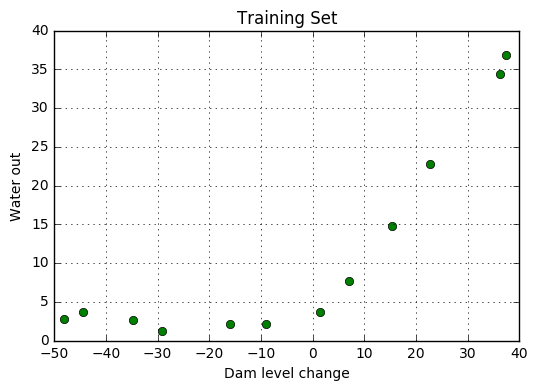

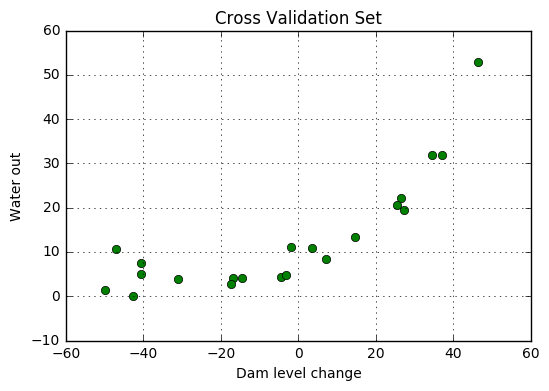

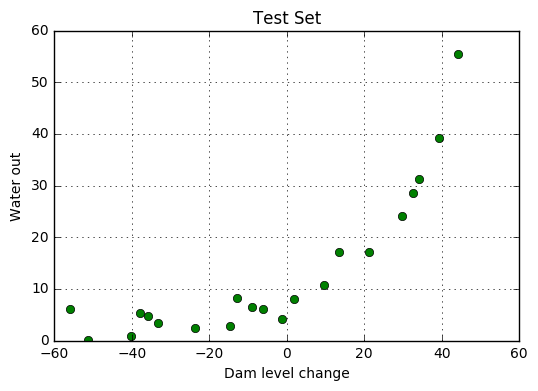

In [4]:
plotScatter(Xtr,ytr,'Training Set','Water out','Dam level change')
plotScatter(Xcv,ycv,'Cross Validation Set','Water out','Dam level change')
plotScatter(Xtest,ytest,'Test Set','Water out','Dam level change')

## Regularized Linear Regression Model

In [5]:
# function to compute h(x)
def h(X, theta):
    return X*theta.T

# function to compute the cost of the entire set as (1/2m)SUM((X·theta'-y)^2) + regularization
def computeCost(theta, X, y, lmbda):
    
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    insides = np.power(h(X, theta) - y, 2) # vector with all insides values
    
    reg = lmbda/(2*len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]],2)) # all thetas except theta[0]

    return np.sum(insides)/(2*len(X)) + reg

In [6]:
# function that computes the gradient for each theta parameter (single step, not the gradient algorithm)
def computeGradient(theta, X, y, lmbda):
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    # init vars
    num_parameters = int(theta.ravel().shape[1])
    gradient = np.zeros(num_parameters)
       
    # compute gradient for each parameter theta
    for i in range(num_parameters):
        term = np.multiply(h(X, theta) - y, X[:,i])
        if (i == 0):
            gradient[i] = np.sum(term) / len(X)
        else:
            gradient[i] = (np.sum(term) / len(X)) + ((lmbda / len(X)) * theta[:,i])
    
    return gradient

In [7]:
# insert 'ones' column in X matrices
Xtr   = np.insert(Xtr  ,0,1,axis=1)
Xcv   = np.insert(Xcv  ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)
print(Xtr.shape, ytr.shape)
print(Xcv.shape, ycv.shape)
print(Xtest.shape, ytest.shape)

(12, 2) (12, 1)
(21, 2) (21, 1)
(21, 2) (21, 1)


In [8]:
# set theta starting values (theta0, theta1) initilaized to (0,0)
thetaStart = np.zeros(Xtr.shape[1],dtype=np.float)
print(thetaStart.shape)

(2,)


In [9]:
# Compute the cost with thetaStart = (0,0) (should be around 140.95...)
computeCost(thetaStart, Xtr, ytr, 0)

140.95412088055392

In [10]:
# Compute the gradient with thetaStart = (0,0) (should be around [-11.21..., -245.65...)
computeGradient(thetaStart, Xtr, ytr, 0)

array([ -11.21758933, -245.65199649])

In [11]:
from scipy import optimize

# just a helper function to call scipy fmin optimzation function
def optimizeTheta(X, y, theta, lmbda):
    # using fmin_tnc (we need to pass gradient)
    result = optimize.fmin_tnc(func=computeCost, 
                               x0=theta, 
                               args=(X, y, lmbda), 
                               fprime=computeGradient)
    return result[0], computeCost(result[0], X, y, lmbda)   
    
    # using minimize (no need to pass gradient)
    #result = optimize.minimize(computeCost, theta, args=(X, y, lmbda),  method='BFGS', options={"maxiter":500, "disp":False} )
    #return result.x, result.fun

In [12]:
# And optimize!
thetaFinal, minCost = optimizeTheta(Xtr, ytr, thetaStart, 0)
print(thetaFinal, minCost)

[ 13.08790351   0.36777923] 22.3739064951


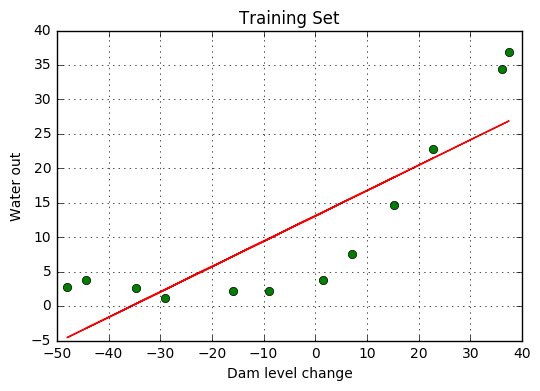

In [13]:
plotScatter(Xtr[:,1],ytr,'Training Set','Water out','Dam level change')
plt.plot(Xtr[:,1], thetaFinal[0] + thetaFinal[1]*Xtr[:,1], 'r-')

Obvously, the single-feature linear fit is not a good model (underfit, high bias)... But let's evaluate with some more formal diagnostics.

## Learning curves

A learning curve plots training and cross validation error as a function of training set size.

In [207]:
# set a theatStart initialized to zeros
thetaStart = np.zeros(Xtr.shape[1],dtype=np.float)

# regularization parameter (note it is not used to compute Jtr and Jcv)
lmbda = 0

# init arrays to store output data for later plotting
m_values, j_tr, j_cv = [], [], []

# loop over training subsets of different sizes (1:1,1:2,1:3,...)
for m in range(1,Xtr.shape[0]+1,1):

    m_values.append(m)

    # train the subset and get theta for the given subset
    theta_subset, cost_subset = optimizeTheta(Xtr[:m,:], ytr[:m], thetaStart, lmbda)

    # compute cost of the training subset (no regularization)
    j_tr.append(computeCost(theta_subset, Xtr[:m,:], ytr[:m], 0))
    
    # compute cost of the cv subset (all samples in cv, not 1:m)(no regularization)
    j_cv.append(computeCost(theta_subset, Xcv, ycv, 0))

# check sizes
print(len(m_values), len(j_tr), len(j_cv))

12 12 12


In [208]:
# function that plots the learning curve
def plotLearningCurve(m_values,j_tr,j_cv,title,x_title,y_title):
    plt.figure(figsize=(6,4))
    plt.plot(m_values, j_tr, 'g-', label='Training')
    plt.plot(m_values, j_cv, 'r-', label='Cross Validation')
    plt.grid(True)
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.legend()

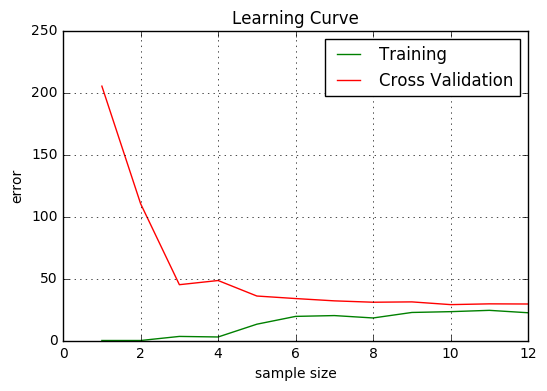

In [209]:
plotLearningCurve(m_values,j_tr,j_cv,'Learning Curve','sample size','error')

We can see that both Jtr and Jcv are large (cost around 20) for large number of training samples m. This indicates that this is a model with high bias (underfitted); that is, the model is too simple for the data. We actually knew this when we plotted the data scatter with the regression line.

## Polynomial model

In order to try to solve the high bias problem we will use a more complex model with more features. Since we have no more information about the damp, we will use a polynomial model where the new features will actually be waterlevel^n.

h(x) = theta0 + theta1·waterLevel + theta2·waterLevel^2 + ... = theta0 + theta1·x1 + theta2·x2 + ...

### Create polynomial features

In [77]:
# function that creates the new polynomial features
def generatePolynomialFeatures(X,p):

    X_poly = X.copy()
    
    # loop polynomial features (columns) to add
    for n in range(p-1):
        dim = n+2
        X_poly = np.insert(X_poly,X_poly.shape[1], np.power(X_poly[:,1],dim), axis=1)
        
    # return the X matrix with the new columns containing the new features
    return X_poly

In [78]:
# function that normalizes a data set (x-mu/sigma)
def normalizeFeatures(X):
    
    Xnorm = X.copy()
    
    # compute means and standdard deviations (column-wise)
    means = np.mean(Xnorm,axis=0)
    std_devs = np.std(Xnorm,axis=0,ddof=1)
    
    # compute normalization
    Xnorm[:,1:] = ( Xnorm[:,1:] - means[1:] ) / std_devs[1:]
        
    return Xnorm, means, std_devs

### Train Polynomial Model

In [153]:
# function that plots the polynomial regression line on top of the scatter data plot
def plotPolynomialFit(theta, original_means, original_std_devs):
    
    # create linear space to plot
    points_to_plot = 50
    x_values = np.linspace(-60, 60, points_to_plot)

    # construct 'fake' x matrix (representing all the points to plot) to compute h(x)
    x_mat = np.ones((points_to_plot,1))
    x_mat = np.insert(x_mat, x_mat.shape[1], x_values.T, axis=1)
    x_mat = generatePolynomialFeatures(x_mat, len(theta)-1)
    
    # normalize using original means and std_devs
    x_mat[:,1:] = x_mat[:,1:] - original_means[1:]
    x_mat[:,1:] = x_mat[:,1:] / original_std_devs[1:]
    
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    x_mat = np.matrix(x_mat)
    
    # plot regression line
    plt.plot(x_values, h(x_mat, theta), 'r-')

Theta: [ 11.21758567  12.02691858  14.49599318   6.89185078  -9.20366154
  -7.44012369]
Cost: 0.20849612412447296


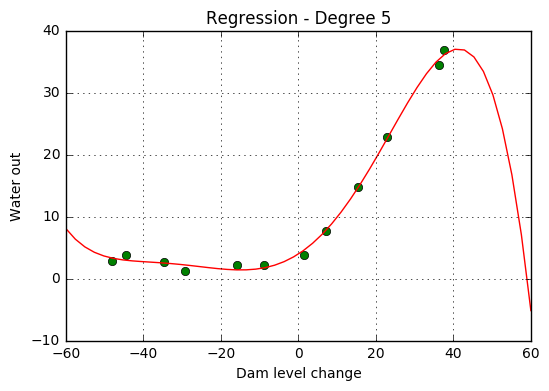

In [219]:
# degree of the polynomial model (polynomial features to construct)
poly_degree = 5

# regularization parameter (note it is not used to compute Jtr and Jcv)
lmbda = 0

# create the normalized polynomial features up to poly_degree
Xtr_poly = generatePolynomialFeatures(Xtr,poly_degree)
Xtr_poly, original_means, original_std_devs = normalizeFeatures(Xtr_poly)

# set a thetaStart initialized to zeros
thetaStart = np.zeros(Xtr_poly.shape[1],dtype=np.float)


# train model
theta_final, cost = optimizeTheta(Xtr_poly, ytr, thetaStart, lmbda)

print("Theta: {0}\nCost: {1}".format(str(theta_final), cost))

# plot scatter data and regression line
plotScatter(Xtr[:,1],ytr,'Regression - Degree '+str(poly_degree),'Water out','Dam level change')
plotPolynomialFit(theta_final, original_means, original_std_devs)

The polynomial fit (of degree 5) clearly fits very well the training points (so we are expecting a low training cost). But also note that it quickly drops for large dam level changes, so this indicates that predicting other data with this model might not end up very well, hence a large cv error is expected.

### Learning Curves

In [220]:
# set a theatStart initialized to zeros
thetaStart = np.zeros(Xtr_poly.shape[1],dtype=np.float)

# create the normalized polynomial features up to poly_degree of the cross validation set
Xcv_poly = generatePolynomialFeatures(Xcv,poly_degree)
Xcv_poly, original_means_cv, original_std_devs_cv = normalizeFeatures(Xcv_poly)

# init arrays to store output data for later plotting
m_values, j_tr, j_cv = [], [], []

# loop over training subsets of different sizes (1:1,1:2,1:3,...)
for m in range(1,Xtr_poly.shape[0]+1,1):
    
    m_values.append(m)
    
    # train the subset and get theta that fits the given subset
    theta_subset, cost_subset = optimizeTheta(Xtr_poly[:m,:], ytr[:m], thetaStart, lmbda)
    
    # compute cost of the training subset (no regularization)
    j_tr.append(computeCost(theta_subset, Xtr_poly[:m,:], ytr[:m], 0))

    # compute cost of the cv subset (all samples in cv, not 1:m)(no regularization)
    j_cv.append(computeCost(theta_subset, Xcv_poly, ycv, 0))

# check sizes
print(len(m_values), len(j_tr), len(j_cv))

12 12 12


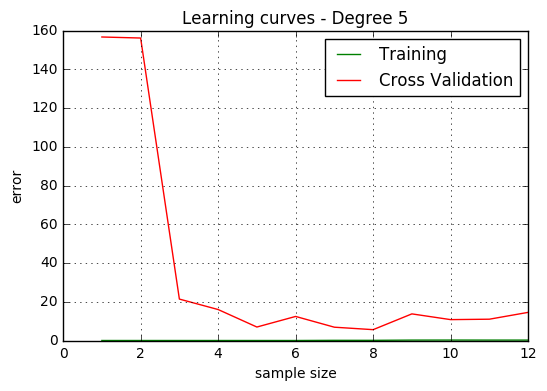

In [221]:
plotLearningCurve(m_values,j_tr,j_cv,'Learning curves - Degree '+str(poly_degree),'sample size','error')

As expected, the training cost is much smaller than the cv cost (note the gap for large sample sizes). This indicates that the model has high variance (or it is overfitted).

Let's check how the model fits the CV data. 

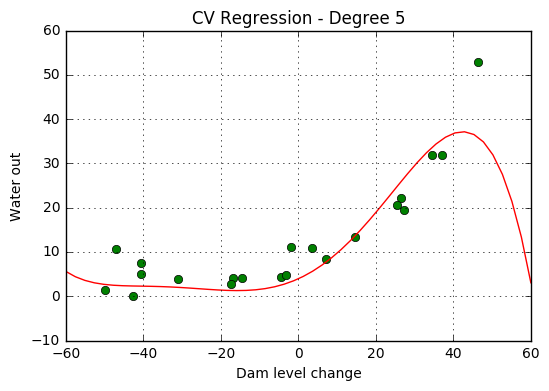

In [222]:
# plot cross validation scatter data and regression line
plotScatter(Xcv[:,1:],ycv,'CV Regression - Degree '+str(poly_degree),'Water out','Dam level change')
plotPolynomialFit(theta_final, original_means_cv, original_std_devs_cv)

O